# ROHP-PAZ Data exploration and modelling

### Ignacio Cobas, Didac Gallego (UAB)

## Introduction

### Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import torch

from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from sklearn.linear_model import TweedieRegressor, PassiveAggressiveRegressor, LogisticRegression, Ridge
from sklearn.linear_model import Lasso, ElasticNet, LassoLars, LinearRegression, BayesianRidge, ARDRegression
from sklearn.linear_model import SGDRegressor, RANSACRegressor, HuberRegressor, QuantileRegressor

from sklearn.cluster import KMeans

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from sklearn.metrics import mean_squared_error

from time import time

import copy

### Data loading

#### Data transformation moved to PAZ-Data_trans

In [2]:
full_data = pd.read_pickle(r'../data/full_data.pkl')
full_data = full_data.drop(['startimeUTC', 'az_surf', 'meanP_2', 'precipBelow12', 'irTemp_2', 'irTemp_below', 'dphi_0010', 'height_flag_comb'], axis=1)

In [3]:
val_data = full_data.iloc[int(full_data.shape[0]*0.7):]
val_data = val_data.reset_index(drop = True)

In [4]:
full_data = full_data.iloc[:int(full_data.shape[0]*0.7)]

### Selecting columns

In [6]:
def get_data_height(full_data, min_height, n_cols=1):
    if min_height < 100:
        min_height = '0' + str(int(min_height))
    else:
        min_height = str(int(min_height))

    start = list(full_data.columns).index(next(filter(lambda c: c[:8] == 'profiles', full_data.columns)))

    data_columns = [c for c in full_data.columns if c[-3:] == min_height] + list(full_data.columns[1:start])

    data = full_data.loc[:, data_columns]
    
    return data

## Model

### Regressors

Moved them to archive/PAZ-Regressors

### Classifiers

In [7]:
def classify_data(data, height=12, profile_threshold=4):
    data_classified = pd.DataFrame(data[data.columns].values, columns=data.columns)
    
    data_classified['rain'] = 0
    data_classified.loc[data_classified.iloc[:, 0] > profile_threshold, 'rain'] = 1
    
    data_classified = data_classified.drop(data.columns[0], axis=1)
    
    return data_classified

In [8]:
profile_threshold = 4
height = 80

In [9]:
data = get_data_height(full_data, height)
data = classify_data(data, height=height, profile_threshold=profile_threshold)

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    VotingClassifier(estimators=[('gnb', GaussianNB()), 
                                 ('qda1', QuadraticDiscriminantAnalysis(reg_param=0.5)),
                                 ('qda2', QuadraticDiscriminantAnalysis(reg_param=0.2))
                                
                                ], voting='hard')
]

In [11]:
error_classifiers = []
times = []
for clf in classifiers:
    st = time()
    clf.fit(X_train, y_train)
    error_classifiers.append(np.round(clf.score(X_test, y_test), 3))
    times.append(np.round(time() - st, 3))
print('Error:', error_classifiers)
print('Time:', times)

Error: [0.99, 0.99, 0.99, 0.927, 0.952, 0.955]
Time: [0.148, 0.17, 1.682, 0.01, 0.016, 0.193]


In [12]:
best_clf = classifiers[np.argmax(error_classifiers)]
print(best_clf)
print(best_clf.score(X_test, y_test))

DecisionTreeClassifier(max_depth=5)
0.9900968783638321


The good results are probably a consequence of the imbalanced dataset, so it should be a good idea to upsample the rain class.

#### Upsampling with SMOTE

https://towardsdatascience.com/upsampling-with-smote-for-classification-projects-e91d7c44e4bf

In [36]:
def upsample_SMOTE(X_train, y_train, ratio=1.0):
    """Upsamples minority class using SMOTE.
    Ratio argument is the percentage of the upsampled minority class in relation
    to the majority class. Default is 1.0
    """
    sm = SMOTE(random_state=23, sampling_strategy=ratio)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    return X_train_sm, y_train_sm

In [37]:
profile_threshold = 4
height = 80

In [38]:
data = get_data_height(full_data, height)
data = classify_data(data, height=height, profile_threshold=profile_threshold)

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train, y_train = upsample_SMOTE(X_train, y_train, 1.0)

In [39]:
error_classifiers = []
times = []
for clf in classifiers:
    st = time()
    clf.fit(X_train, y_train)
    error_classifiers.append(np.round(clf.score(X_test, y_test), 3))
    times.append(np.round(time() - st, 3))
print('Error:', error_classifiers)
print('Time:', times)

Error: [0.893, 0.913, 0.889, 0.887, 0.915, 0.911]
Time: [0.305, 0.341, 3.799, 0.015, 0.033, 0.233]


In [40]:
best_clf = classifiers[np.argmax(error_classifiers)]
print(best_clf)
print(best_clf.score(X_test, y_test))

QuadraticDiscriminantAnalysis()
0.9148188015787585


### One model per height

In [42]:
def model_every_height(full_data, parameters):
    # parameters
    profile_threshold = parameters['profile_threshold']
    max_height = parameters['max_height']
    min_height = parameters['min_height']
    step = parameters['step']
    classifier = parameters['classifier']

    # predictions = dict.fromkeys(range(min_height, max_height, step))
    # scores = dict.fromkeys(range(min_height, max_height, step))

    scores = dict.fromkeys(['Total', 'Rain1', 'Rain0'], np.array([]))
    classifiers = dict.fromkeys(range(min_height, max_height, step))
   
    # height loop
    for height in range(min_height, max_height, step):
        classifier = parameters['classifier']
        try:
            # get data
            data = get_data_height(full_data, height)
            data = classify_data(data, height, profile_threshold)

            X = data.iloc[:, :-1]
            y = data.iloc[:, -1]
            
            X_train, X_test, y_train, y_test = train_test_split(X, y)
            
            # upsample
            data_upsampled = upsample_SMOTE(X_train, y_train, 0.5)
            
            # Train
            classifier.fit(X_train, y_train)

            # Test
            total = classifier.predict(X_test)
            rain1 = classifier.predict(X_test[y_test == 1])
            rain0 = classifier.predict(X_test[y_test == 0])
            
            # predictions[height] = {'Total': total, 'Rain1': rain1, 'Rain0': rain0}
            
            total = (total == y_test).mean()
            rain1 = (rain1 == 1).mean()
            rain0 = (rain0 == 0).mean()
            
            # scores[height] = {'Total': total, 'Rain1': rain1, 'Rain0': rain0}
            
            scores['Total'] = np.append(scores['Total'], total)
            scores['Rain1'] = np.append(scores['Rain1'], rain1)
            scores['Rain0'] = np.append(scores['Rain0'], rain0)
            
            classifiers[height] = copy.deepcopy(classifier)

        except Exception as e:
            # predictions[height] = {'Total': -1, 'Rain1': -1, 'Rain0': -1}
            # scores[height] = {'Total': 0, 'Rain1': 0, 'Rain0': 0}
            
            scores['Total'] = np.append(scores['Total'], 0)
            scores['Rain1'] = np.append(scores['Rain1'], 0)
            scores['Rain0'] = np.append(scores['Rain0'], 0)
            
            classifiers[height] = None
            
    scores = pd.DataFrame(scores)
    scores.index = range(min_height, max_height, step)
    
    return scores, classifiers #, predictions

In [43]:
classifier = VotingClassifier(estimators=[('gnb1', GaussianNB()),
                                          ('gnb2', GaussianNB()),
                                          ('gnb3', GaussianNB()),
                                          ('gnb4', GaussianNB()),
                                          ('gnb5', GaussianNB()),
                                          ('qda1', QuadraticDiscriminantAnalysis(reg_param=0.1)),
                                         ], voting='hard')

# by setting min height to 60 and max height to 140, precision goes to 80%
# at very low heights (or very high) there probably are very few rain clouds,
# which means that upsampling does not have much to start with, so it doesn't do very well

parameters = {
    'profile_threshold': 2,
    'max_height': 142,
    'min_height': 60,
    'step': 2,
    'classifier': classifier
}

In [74]:
scores, classifiers = model_every_height(full_data, parameters)

### Building a regression

In [78]:
precision_parameters = {
    'min_profile_threshold': 1,
    'max_profile_threshold': 5,
    'precision': 10,
    
    'max_height': 140,
    'min_height': 60,
    'step': 2,
}

In [41]:
def precision_model_per_layer(full_data, precision_parameters):
    min_profile_threshold = precision_parameters['min_profile_threshold']
    max_profile_threshold = precision_parameters['max_profile_threshold']
    precision = precision_parameters['precision']
    
    # list(np.linspace(min_profile_threshold, max_profile_threshold, precision))
    results = dict.fromkeys(np.linspace(min_profile_threshold, max_profile_threshold, precision))
    
    for profile_threshold in np.linspace(min_profile_threshold, max_profile_threshold, precision):
        
        parameters = {
            'profile_threshold': profile_threshold,
            'max_height': precision_parameters['max_height'],
            'min_height': precision_parameters['min_height'],
            'step': precision_parameters['step'],
            'classifier': classifier
        }
        
        scores, classifiers = model_every_height(full_data, parameters)
        
        results[profile_threshold] = {'Score': scores, 'Classifiers': classifiers}

    return results

In [80]:
results = precision_model_per_layer(full_data, precision_parameters)

/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [92]:
list(results.keys())

[1.0,
 1.4444444444444444,
 1.8888888888888888,
 2.333333333333333,
 2.7777777777777777,
 3.2222222222222223,
 3.6666666666666665,
 4.111111111111111,
 4.555555555555555,
 5.0]

In [108]:
results[list(results.keys())[0]]['Score'].Rain1.mean()

0.5037928158428088

In [723]:
def regression_prediction(results, precision_parameters):
    max_height = precision_parameters['max_height']
    min_height = precision_parameters['min_height']
    step = precision_parameters['step']

    min_profile_threshold = precision_parameters['min_profile_threshold']
    max_profile_threshold = precision_parameters['max_profile_threshold']
    precision = precision_parameters['precision']

    predictions = dict.fromkeys(range(min_height, max_height, step), dict.fromkeys(np.linspace(min_profile_threshold, max_profile_threshold, precision)))
    
    for height in range(min_height, max_height, step):
        for profile_threshold in np.linspace(min_profile_threshold, max_profile_threshold, precision):
            data = get_data_height(val_data, height)
            data = classify_data(data, height, profile_threshold)

            classifier = results[profile_threshold]['Classifiers'][height]

            X = data.iloc[:, :-1]
            y = data.iloc[:, -1]

            try:
                predictions[height][profile_threshold] = copy.deepcopy(classifier.predict(X))
            except AttributeError:
                predictions[height][profile_threshold] = None

        # if prediction is 1, means its higher than that threshold
        # so we sum to know how many 'higher than' we got
        # its not perfect, because its not 100% true that
        # when a classifier says higher, the last one said higher as well
        # but i have seen that it was more than 95% likely
        # and this allows me to simplify this very much
        predictions[height] = pd.DataFrame(predictions[height]).sum(axis=1)

        profile_thresholds = list(results.keys())

        # profile thresholds are now the values in between the thresholds, so we add one more to the end of the list
        profile_thresholds -= (profile_thresholds[1] - profile_thresholds[0])/2
        profile_thresholds = np.append(profile_thresholds, profile_thresholds[-1] + 2*(profile_thresholds[1] - profile_thresholds[0])/2)

        # transforming from one linear space to another one
        # profile_threshold = m * prediction + n
        m = profile_thresholds[1] - profile_thresholds[0]
        n = profile_thresholds.min()

        predictions[height] *= m
        predictions[height] += n
    
    predictions = pd.DataFrame(predictions)
    
    return predictions

In [ ]:
predictions = regression_prediction(results, precision_parameters)

In [ ]:
predictions

In [714]:
# rainy days according to model
rainy = []
for i in range(predictions.shape[0]):
    if (predictions.iloc[i] > 4.3).sum() > 10:
        rainy.append(i)
print(len(rainy))

1231


profiles_h058    0.507519
profiles_h060    0.272313
profiles_h062    0.319891
profiles_h064   -0.046141
profiles_h066   -0.018834
profiles_h068    0.160531
profiles_h070    0.509882
profiles_h072    0.575662
profiles_h074    0.503398
profiles_h076   -0.117727
profiles_h078   -0.943661
profiles_h080   -0.440998
profiles_h082     1.79211
profiles_h084    0.806526
profiles_h086   -0.598274
profiles_h088   -0.169537
profiles_h090   -0.050793
profiles_h092    0.137485
profiles_h094    -0.40516
profiles_h096   -0.600271
profiles_h098   -0.455257
profiles_h100   -0.116482
profiles_h102   -0.230781
profiles_h104    0.198316
profiles_h106   -0.012136
profiles_h108   -0.072762
profiles_h110    0.365702
profiles_h112    0.679315
profiles_h114    0.809451
profiles_h116     1.01272
profiles_h118    0.946376
profiles_h120    0.817804
profiles_h122    0.505322
profiles_h124    0.282901
profiles_h126     0.19444
profiles_h128   -0.096389
profiles_h130   -0.071827
profiles_h132   -0.088138
profiles_h13

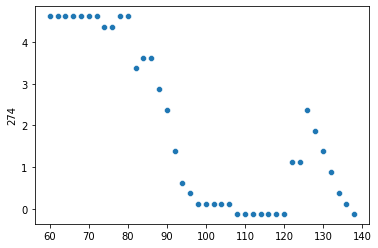

In [715]:
i = 14
x = predictions.iloc[rainy[i]].index
y = predictions.iloc[rainy[i]]
sns.scatterplot(x=x, y=y)

val_data.iloc[rainy[i]][val_data.columns[16:56]]

In [716]:
# rainy days according to data
rainy = []
for i in range(val_data.shape[0]):
    if (val_data.iloc[i, 17:68] > 3).sum() > 5:
        rainy.append(i)
print(len(rainy))

477


profiles_h058      3.6093
profiles_h060     4.79088
profiles_h062     5.99487
profiles_h064     6.20084
profiles_h066     6.19939
profiles_h068     5.78752
profiles_h070     5.33435
profiles_h072     5.45387
profiles_h074     5.35306
profiles_h076      5.7203
profiles_h078     5.79342
profiles_h080     6.04356
profiles_h082     5.79545
profiles_h084     5.31071
profiles_h086     5.52499
profiles_h088     4.97084
profiles_h090     4.57796
profiles_h092     4.16941
profiles_h094     3.13863
profiles_h096     2.55955
profiles_h098     2.18524
profiles_h100     1.86472
profiles_h102     1.49535
profiles_h104     1.59856
profiles_h106     1.54138
profiles_h108     1.00924
profiles_h110    0.881321
profiles_h112    0.726307
profiles_h114    0.315233
profiles_h116     0.00973
profiles_h118   -0.055887
profiles_h120   -0.105541
profiles_h122   -0.014525
profiles_h124    0.232878
profiles_h126    0.249062
profiles_h128    0.079994
profiles_h130    0.080302
profiles_h132    0.192306
profiles_h13

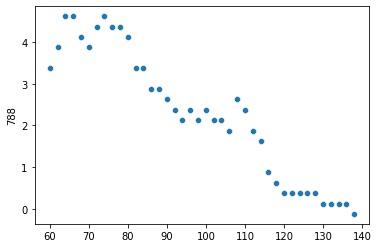

In [722]:
i = 13
x = predictions.iloc[rainy[i]].index
y = predictions.iloc[rainy[i]]
sns.scatterplot(x=x, y=y)

val_data.iloc[rainy[i]][val_data.columns[16:56]]

In [701]:
(val_data.iloc[0, 17:68].max() > 3)

False